# **Praktikum 1**

RNN untuk Analisis Sentimen

### **Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [20]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"The Last Hard Men finds James Coburn an outlaw doing a long sentence breaking free from a chain gang. Do he and his friends head for the Mexican border from jail and safety. No they don't because Coburn has a mission of revenge. To kill the peace officer who brought him in and in the process killed his woman.<br /><br />That peace officer is Charlton Heston who is now retired and he knows what Coburn is after. As he explains it to his daughter, Barbara Hershey, Coburn was holed up in a shack and was involved in a Waco like standoff. His Indian woman was killed in the hail of bullets fired. It's not something he's proud of, she was a collateral casualty in a manhunt.<br /><br />Lest we feel sorry for Coburn he lets us know full well what an evil man he truly is. Heston is his usual stalwart hero, but the acting honors in The Last Hard Men go to James Coburn. He blows everyone else off the screen when he's on. <br /><br />Coburn gets the bright idea of making sure Heston trail

### **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)

[[  2 226 264 ...   0   0   0]
 [131  10  14 ...   0   0   0]
 [  1 444  11 ...   0   0   0]]


Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu: 

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation". 

- pl
l
ppppppppppppppppppppppp'kuy3542Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"The Last Hard Men finds James Coburn an outlaw doing a long sentence breaking free from a chain gang. Do he and his friends head for the Mexican border from jail and safety. No they don't because Coburn has a mission of revenge. To kill the peace officer who brought him in and in the process killed his woman.<br /><br />That peace officer is Charlton Heston who is now retired and he knows what Coburn is after. As he explains it to his daughter, Barbara Hershey, Coburn was holed up in a shack and was involved in a Waco like standoff. His Indian woman was killed in the hail of bullets fired. It's not something he's proud of, she was a collateral casualty in a manhunt.<br /><br />Lest we feel sorry for Coburn he lets us know full well what an evil man he truly is. Heston is his usual stalwart hero, but the acting honors in The Last Hard Men go to James Coburn. He blows everyone else off the screen when he's on. <br /><br />Coburn gets the bright idea of making sure Heston tra

### **Buat Model**

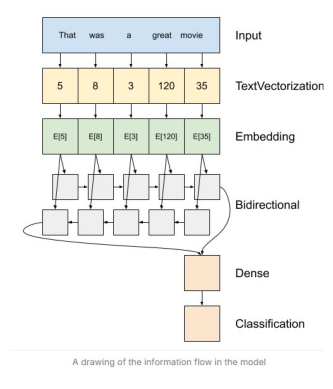

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('assets/gambar_1.jpg')

plt.imshow(img)
plt.axis('off')  
plt.show()

Diagram model dapat dilihat pada gambar diatas

Model ini dapat dibuat sebagai tf.keras.Sequential.

 Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token. 

Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense. 

Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya. 

Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir. 

-Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran. 

-Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir. 

Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada Keras RNN guide 

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan 

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [21]:
# Sample text for prediction
sample_text = 'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'

# Encode the sample text directly
encoded_sample_text = encoder(np.array([sample_text]))  # Ensure it is a 1D array of strings

# Print the encoded sample text
print("Encoded sample text:", encoded_sample_text.numpy())  # Convert to numpy array for visualization

# Make predictions using the encoded text
predictions = model.predict(encoded_sample_text)
print(predictions[0])


Encoded sample text: [[  2  18  14 652   2 737   3   2   1  66  46   5  11 188  10  59 368  11
   18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


AttributeError: 'NoneType' object has no attribute 'numpy'